In [52]:
# portfolio_data.py

# Dictionary to store your portfolio holdings
portfolio = {
    "1_year_T_Bills": {
        "type": "long",
        "quantity": 20000 // 94.88,  # integer division to get the number of bonds
        "purchase_price": 94.88,
        "maturity": 1,  # in years
        "coupon_rate": 0.0,  # T-bills are zero-coupon
        "ytm": 0.054  # 0.054% yield converted to a decimal
    },
    "10_year_T_Bonds": {
        "type": "short",
        "quantity": 20000 // 97.1,  # integer division to get the number of bonds
        "purchase_price": 97.1,
        "maturity": 10,  # in years
        "coupon_rate": 0.0388,  # 3.88% coupon rate converted to a decimal
        "ytm": 0.04241  # 4.241% yield converted to a decimal
    }
}


In [53]:
import numpy_financial as npf

def generate_cashflows(maturity, coupon_payment):
    """
    Generates cash flows for a bond based on its maturity and coupon payment.

    Parameters:
    - maturity (int): Number of years to maturity.
    - coupon_payment (float): Amount of the semi-annual coupon payment.

    Returns:
    - list: List of cash flows, including the $100 face value payment at the end.
    """

    # Calculate the total number of coupon payments (semi-annual)
    total_payments = maturity * 2

    # Generate cash flows
    cashflows = [coupon_payment] * total_payments

    # Add the $100 face value payment to the end
    cashflows.append(100)

    return cashflows


def duration(bond_price, coupon_rate, maturity, ytm): #need bond price, face value and coupons, maturity, ytm, coupon payments, array of cash flows
  weighted_average = 0
  for i in range(1, (maturity * 2) + 1):
    cashflows = [0] * (i - 1)
    cashflows.append(100 * coupon_rate/2)
    weighted_average += i * npf.npv(ytm/2, cashflows)
  weighted_average += (maturity * 2) * npf.npv(ytm/2, generate_cashflows(maturity, 0))
  return weighted_average, weighted_average/(2 * bond_price) #want to get annual duration instead of semiannual




In [54]:

def bond_duration(bond_info):
    """
    Compute the bond duration for a given bond's information.

    Parameters:
    - bond_info (dict): Dictionary containing bond's information.

    Returns:
    - float: Bond duration.
    """
    bond_price = bond_info["purchase_price"]
    coupon_rate = bond_info["coupon_rate"]
    maturity = bond_info["maturity"]
    ytm = bond_info["ytm"]

    _, dur = duration(bond_price, coupon_rate, maturity, ytm)
    return 2*dur / (1 + ytm/2) #modified duration



Modified Duration of 1_year_T_Bills: 1.95 %
Modified Duration of 10_year_T_Bonds: 16.42 %


In [55]:
def calculate_convexity(P, C, M, YTM, n, m):
    """
    Calculate the convexity of a bond.

    Parameters:
    - P (float): bond price.
    - C (float): coupon payment.
    - M (float): maturity value.
    - YTM (float): yield to maturity.
    - n (int): total number of coupon payments till maturity.
    - m (int): number of payment periods per year.

    Returns:
    - float: Convexity of the bond.
    """

    convexity = 0

    for t in range(1, n+1):
        convexity += (C / (1 + YTM/m)**t) * (t * (t + 1)) / m**2

    convexity += (M / (1 + YTM/m)**n) * (n * (n + 1)) / m**2
    convexity = convexity / ((1 + YTM/m)**2 * P)

    return convexity



In [56]:
def bond_price_change_estimate(P, duration, convexity, delta_y):
    """
    Estimate the bond price change for a given change in yield using duration and convexity.

    Parameters:
    - P (float): Initial bond price.
    - duration (float): Modified duration of the bond.
    - convexity (float): Convexity of the bond.
    - delta_y (float): Change in yield.

    Returns:
    - float: Estimated bond price change.
    """

    price_change = (-duration * delta_y + 0.5 * convexity * delta_y**2) * P
    return price_change


1_year_T_Bills - Duration: 1.00, Convexity: 1.4211, Estimated Price Change: -0.94
10_year_T_Bonds - Duration: 8.39, Convexity: 78.9049, Estimated Price Change: -7.76


<ipython-input-57-e8445e2df34a>:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


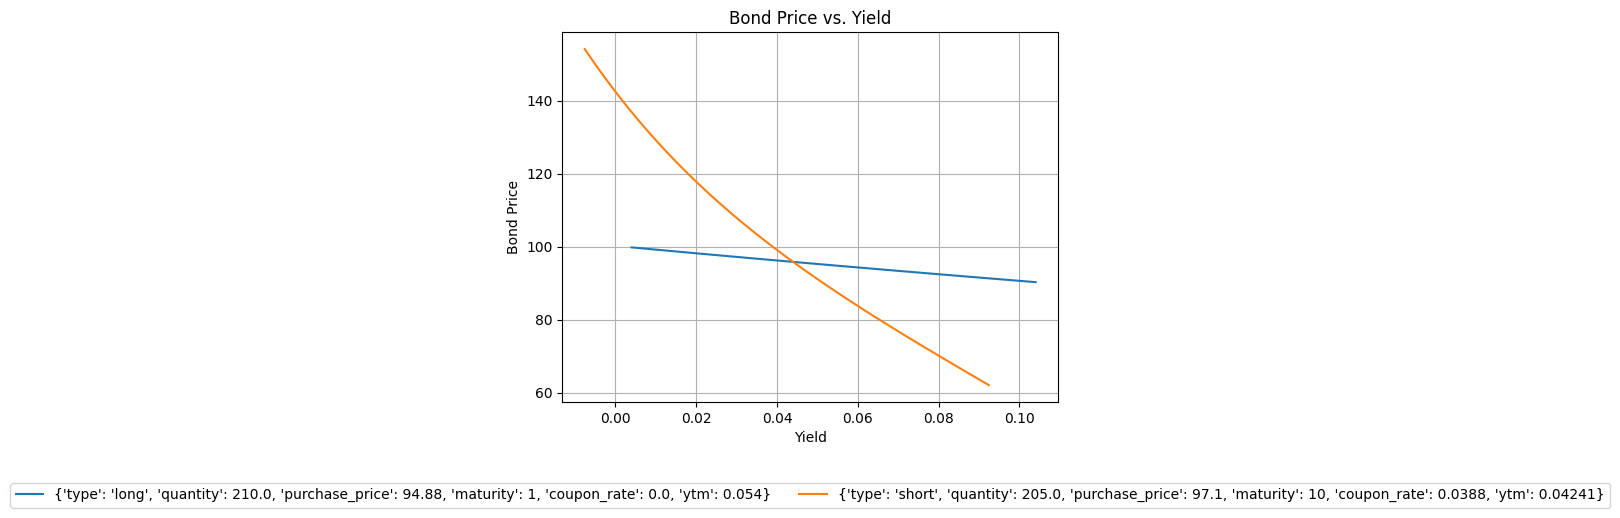

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def bond_metrics_and_plot(bond_name, bond, P, C, M, YTM, n, m, delta_y):
    # Calculate duration, convexity, and estimated price change
    duration_value = duration(P, bond["coupon_rate"], bond["maturity"], bond["ytm"])[1]
    convexity_value = calculate_convexity(P, C, M, YTM, n, m)
    estimated_change = bond_price_change_estimate(P, duration_value, convexity_value, delta_y)

    # Print the metrics
    print(f"{bond_name} - Duration: {duration_value:.2f}, Convexity: {convexity_value:.4f}, Estimated Price Change: {estimated_change:.2f}")

    # Plotting bond price with regard to yield
    yields = np.linspace(YTM-0.05, YTM+0.05, 100)  # varying YTM by +- 5% for illustration
    prices = [P + bond_price_change_estimate(P, duration_value, calculate_convexity(P, C, M, y, n, m), y - YTM) for y in yields]

    plt.plot(yields, prices, label=bond)

# For each bond in the portfolio
for bond_name, bond_data in portfolio.items():
    P = bond_data["purchase_price"]
    C = bond_data["coupon_rate"] * 100 / 2  # Semiannual coupon payment
    M = 100  # Maturity value
    YTM = bond_data["ytm"]
    n = bond_data["maturity"] * 2  # Total number of semiannual payments
    m = 2  # semiannual

    bond_metrics_and_plot(bond_name, bond_data, P, C, M, YTM, n, m, 0.01)

# Show the plot
plt.xlabel('Yield')
plt.ylabel('Bond Price')
plt.title('Bond Price vs. Yield')
plt.legend()
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(portfolio))
plt.tight_layout()
plt.show()




In [58]:
!pip install numpy_financial